## Import packages

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.python.client import timeline
%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Import the MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)
X_tr=mnist.train.images
Y_tr=mnist.train.labels
X_te=mnist.test.images
Y_te=mnist.test.labels
X_val=mnist.validation.images
Y_val=mnist.validation.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

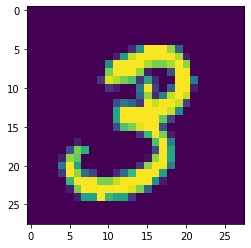

In [3]:
plt.imshow(np.reshape(X_tr[1,:],[28,28]))

## Apply permutation for the psMNIST

In [4]:
P=np.shape(X_tr)[1]
permutation=np.random.permutation(P)

X_tr=X_tr[:,permutation]
X_te=X_te[:,permutation]
X_val=X_val[:,permutation]

## Class to compute the ESN response

The input should be:
<ul>
    <li> alpha1: leakage term of the reservoir </li>
    <li> pho1: $\rho$ of the reservoir </li>
    <li> diluition1: probability of a zero in the connectivity matrix </li> 
    <li> N1: number of nodes of the ESN </li>
    <li> W1_in: input connectivity matrix </li>
    <li> T_conc: the multiples of T_conc define the values for the readout </li>
    
</ul>

In [5]:
class Echo:
    
    def __init__(self,alpha1, pho1, diluition1, N1, W1_in, T_conc):
                
            ## Reservoir 1
        
            self.N1=N1
            
            ## alpha 1
            self.alpha1=tf.constant(alpha1,dtype=tf.float32)
            
            ## W1 def
            W1_np=np.random.uniform(-1,1,[N1,N1])
            D=np.random.uniform(0,1,(N1,N1))>np.ones((N1,N1))*diluition1
            W1_np=W1_np*D.astype(int)
            
            eig1=np.linalg.eigvals(W1_np)

            W1_np=pho1*W1_np/(np.max(np.absolute(eig1)))
            self.W1=tf.Variable(W1_np,trainable=False,dtype=tf.float32)
            
            self.eig1=eig1
            
            ## Input W
            self.W1_in=tf.Variable(W1_in,trainable=False,dtype=tf.float32)
            
            ## The multiples of T_conc are the values of t at which the ESN representations are concatenated
            self.T_conc=T_conc
            
    
    # Computation of the states of the reservoir
    def train_graph(self,T,init_state1,inputs,return_all=False):

        
        state1=init_state1
        states_train1=[]
        
        
        for t in range(T):
            
            prev_state1=tf.identity(state1)
            
            state1 = (1-self.alpha1)*prev_state1+self.alpha1*tf.tanh( tf.matmul(prev_state1,self.W1)\
                                                                     +tf.tile(tf.expand_dims(inputs[:,t],1),[1,self.N1])*self.W1_in )
                                                    
            
            if return_all:
                
                states_train1.append(state1)
                
                
            elif (t+1)%self.T_conc==0:
                
                states_train1.append(state1)
                
                
                
        states1=tf.concat([tf.expand_dims(s,2) for s in states_train1],2)
        
        
        return  states1
        
        

## Definition of the input connectivity

In [6]:
def W_input(N1):

    W1_In=np.ones(N1)
    W1_In[np.random.uniform(0,1,N1)<0.5]=-1
    
    
    return W1_In

## ESN representation over the dataset

The data are splitted because of the limited memory in my gpu

In [7]:
def Echo_representations(alpha1, pho1, diluition1, N1, W1_in, X_tr, X_val, X_test, T_size):

    T=np.shape(X_tr)[1]
    N_class=np.shape(Y_tr)[1]
    
    T_conc=np.int(T/T_size)
    
    rnn=Echo(alpha1, pho1, diluition1, N1, W1_in, T_conc)

    init_state1=tf.placeholder(tf.float32,[None,N1])
    s=tf.placeholder(tf.float32,[None,T])

    states=rnn.train_graph(T,init_state1,s,return_all=False)

    init=tf.global_variables_initializer()
    
    train_divide=100
    N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

    test_divide=50
    N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))
    
    val_divide=50
    N_val_d=int(np.floor(np.shape(Y_val)[0]/val_divide))

    States=np.zeros([N_train_d*train_divide,N,T_size])
    States_test=np.zeros([N_test_d*test_divide,N,T_size])
    States_val=np.zeros([N_val_d*val_divide,N,T_size])

    with tf.Session() as sess:

        sess.run(init)
        
        print('Training Data')

        for l in range(train_divide):

            images=np.copy(X_tr[l*N_train_d:(l+1)*N_train_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_train_d,N1]),s:images})

            States[l*N_train_d:(l+1)*N_train_d,:,:]=states_

            
        print('Testing Data')

        for l in range(test_divide):

            images=np.copy(X_te[l*N_test_d:(l+1)*N_test_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_test_d,N1]),s:images})

            States_test[l*N_test_d:(l+1)*N_test_d,:,:]=states_    
            
       
        print('Validating Data')

        for l in range(val_divide):

            images=np.copy(X_val[l*N_val_d:(l+1)*N_val_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_val_d,N1]),s:images})

            States_val[l*N_val_d:(l+1)*N_val_d,:,:]=states_
        
    
    return States, States_test, States_val


## Tensorflow graph for the training
It loops over the parameters considered in the grid search

In [19]:
from scipy import io

## Simulation 

init=tf.global_variables_initializer()

N_size=np.shape(X_tr)[0]

# Training parameters
N_train=100000          # Number of training iteration
alpha_size=0.0005       # Learning rate
batch_size=20
T_size=28               # Number of hidden states used for the readout (they are equally spaced across the input sequence)

N_class=np.shape(Y_tr)[1]

#  Defines the values at which the performance are computed 
N_check=15
T_checks=np.concatenate([np.linspace(10000,90000,5),np.linspace(91000,100000,N_check-5)],0) 

# Number of times the test, validation and training dataset are divided
test_divide=2
val_divide=2
train_divide=10

N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))
N_val_d=int(np.floor(np.shape(Y_val)[0]/val_divide))
N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

N_grid=10

p_ra_test=np.zeros([N_grid,N_grid,N_check])
p_ra_train=np.zeros([N_grid,N_grid,N_check])
p_ra_val=np.zeros([N_grid,N_grid,N_check])

## Network parameters
N1=1200                 # Network size
N1_av=5                 # Average number of connections for a node in the ESN

diluition1=1-N1_av/N1   # Probability of a zero in the connectivity matrix

# Values of alpha used, the program computes the performance for each of them
alpha1=np.exp(np.linspace(-5,0,N_grid)) 

pho1=0.985              # Value of \rho
gamma1=1                # Multiplicative factor of the input connectivity

    
## Training    
        
for i in range(0,N_grid):

    for j in range(N_grid-1,N_grid): # This loop exists if one wants to do a grid search over another parameter

        tf.reset_default_graph()
        index_help=0

        W1_in=W_input(N1)
        W1_in=gamma1*W1_in.T

        print('Simulation ', i*N_grid+j, ', alpha1=',alpha1[i])
        print('Processing Resrvoir Representations: ')
        
        # Computation of the ESN representation, saved in the arrays States (train), States_test (Test), States_val (validation)
        States, States_test, States_val=Echo_representations(alpha1[i], pho1, diluition1, N1, W1_in,
                                 X_tr, X_val, X_te, T_size)

        print('Start Training: ')
        
        # Definition of the graph fpr the training
        # The placeholder s receives the representations of the ESN used for the readout (for the specific batch_size sequences considered) 
        s=tf.placeholder(tf.float32,[None,N,T_size])
        V=tf.reshape(s,[-1,T_size*N])

        y_true=tf.placeholder(tf.float32,[None,N_class])

        W_out=tf.Variable(np.random.uniform(-1,1,[N*T_size,N_class])/(N),dtype=tf.float32)

        y=tf.matmul(V,W_out)

        error=tf.losses.sigmoid_cross_entropy(y_true,y)

        train=tf.train.AdamOptimizer(learning_rate=alpha_size).minimize(error,var_list=[W_out])

        init=tf.global_variables_initializer()

        with tf.Session() as sess:

            sess.run(init)

            for n in range(N_train):

                if n>0:

                    rand_ind=np.random.randint(0,N_size,(batch_size,))

                    images=States[rand_ind,:,:]

                    labels=Y_tr[rand_ind,:]

                    _=sess.run(train,feed_dict={y_true:labels,s:images})

                # If the following condition is true, the program will compute the performance over the test and validation data
                if n==T_checks[index_help]:

                    index_help=index_help+1
                    
                    matches=tf.equal(tf.argmax(y_true,1),tf.argmax(y,1))
                    p=tf.reduce_mean(tf.cast(matches,tf.float32))
                    
                    
                    # Performance on the test data, computed as a mean over the different splits of the dataset through the variable p_ra_ and error_ 
                    p_ra_=0
                    error_=0

                    for l in range(test_divide):

                        images=States_test[l*N_test_d:(l+1)*N_test_d,:,:]
                        labels=Y_te[l*N_test_d:(l+1)*N_test_d,:]

                        p_ra1_,error1_=sess.run([p,error],feed_dict={y_true:labels,s:images})

                        p_ra_=p_ra_+p_ra1_/test_divide
                        error_=error_+error1_/test_divide


                    p_ra_test[i,j,index_help]=p_ra_

                    #print('Iteration: ',n,'Reservoir ',i,'Probability: ',p_ra_,'Error: ',error_)

                    # Performance on the validation data, computed as a mean over the different splits of the dataset through the variable p_ra_ and error_ 
                    p_ra_v=0
                    error_v=0

                    for l in range(val_divide):

                        images=States_val[l*N_val_d:(l+1)*N_val_d,:,:]
                        labels=Y_val[l*N_val_d:(l+1)*N_val_d,:]

                        p_ra3_,error3_=sess.run([p,error],feed_dict={y_true:labels,s:images})

                        p_ra_v=p_ra_v+p_ra3_/val_divide
                        error_v=error_v+error3_/val_divide

                    p_ra_val[i,j,index_help]=p_ra_v

                    print('Iteration: ',n,'Reservoir ',i,'Probability: ',p_ra_v,'Error: ',error_v)

            # Saving the data
            #io.savemat("AccSingleEcho1_test_"+repr(i)+"_"+repr(j)+".mat",{"array": p_ra_test[i,j,:]})
            #io.savemat("AccSingleEcho1_val_"+repr(i)+"_"+repr(j)+".mat",{"array": p_ra_val[i,j,:]})


Simulation  9 , alpha1= 0.006737946999085467
Processing Resrvoir Representations: 
Training Data
Testing Data
Validating Data
Start Training: 
Iteration:  10000 Reservoir  0 Probability:  0.7350000143051147 Error:  0.15922730416059494
Iteration:  30000 Reservoir  0 Probability:  0.7173999845981598 Error:  0.16655051708221436
Iteration:  50000 Reservoir  0 Probability:  0.7409999966621399 Error:  0.15850575268268585
Iteration:  70000 Reservoir  0 Probability:  0.6933999955654144 Error:  0.185210719704628
Iteration:  90000 Reservoir  0 Probability:  0.7236000001430511 Error:  0.16543208807706833
Iteration:  91000 Reservoir  0 Probability:  0.7502000033855438 Error:  0.14900782704353333
Iteration:  92000 Reservoir  0 Probability:  0.7525999844074249 Error:  0.14964110404253006
Iteration:  93000 Reservoir  0 Probability:  0.7452000081539154 Error:  0.15165464580059052
Iteration:  94000 Reservoir  0 Probability:  0.7477999925613403 Error:  0.16017241030931473
Iteration:  95000 Reservoir  0 

KeyboardInterrupt: 

In [ ]:
io.savemat("Alphas.mat",{"array": alpha1})

In [15]:
tf.reset_default_graph()